In [2]:
import cv2
import numpy as np
from skimage import exposure
from scipy.ndimage import interpolation as inter
import matplotlib.pyplot as plt

In [17]:

# def illumination_adjustment(image):
#     # Convert to grayscale
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     # Histogram Equalization
#     hist_eq = cv2.equalizeHist(gray)
#     # Adaptive Gamma Correction
#     gamma_corrected = exposure.adjust_gamma(hist_eq, gamma=1.0)
#     return gamma_corrected


In [3]:
def orientation_correction(image):
    # Convert to grayscale if not already
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    # Edge detection
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    # Hough Line Transform
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    
    if lines is not None:
        # If lines are detected, calculate rotation angle
        angles = []
        for rho, theta in lines[:, 0]:
            angle = np.degrees(theta) - 90
            if angle > 45:
                angle -= 90
            elif angle < -45:
                angle += 90
            angles.append(angle)
        
        # Average angle
        if angles:
            angle = np.mean(angles)
            # Rotate image
            if len(image.shape) == 2:  # Single channel
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            return inter.rotate(image, angle, reshape=False, mode='nearest')
    
    return image

In [4]:
def resolution_optimization(image, target_dpi=300):
    height, width = image.shape[:2]
    scale = target_dpi / 96  # Assuming original DPI is 96
    new_size = (int(width * scale), int(height * scale))
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
    return resized_image

In [5]:
def grayscale_conversion(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


In [23]:
def binarization(image):
    # Convert to grayscale if not already
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # binary_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    #                                       cv2.THRESH_BINARY, 31, 9) 
    return binary_image

In [7]:
def noise_reduction(image):
    return cv2.medianBlur(image, 3)

In [8]:
def unsharp_masking(image):
    blurred = cv2.GaussianBlur(image, (9, 9), 10.0)
    sharpened = cv2.addWeighted(image, 1.5, blurred, -0.5, 0)
    return sharpened

In [9]:
def normalization(image):
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return normalized_image


In [25]:
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    #Step 1: Illumination Adjustment
    # image = illumination_adjustment(image)
    
    # Convert to 3-channel image if needed
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Step 2: Orientation Correction
    #image = orientation_correction(image)
    
    # Convert to 3-channel image if needed
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Step 3: Resolution Optimization
    image = resolution_optimization(image)
    
    # Step 4: Grayscale Conversion
    image = grayscale_conversion(image)
    
    # Step 5: Binarization
    image = binarization(image)
    
    # Step 6: Noise Reduction
    image = noise_reduction(image)
    
    # Step 7: Unsharp Masking
    image = unsharp_masking(image)
    
    # Step 8: Normalization
    image = normalization(image)
    
    return image

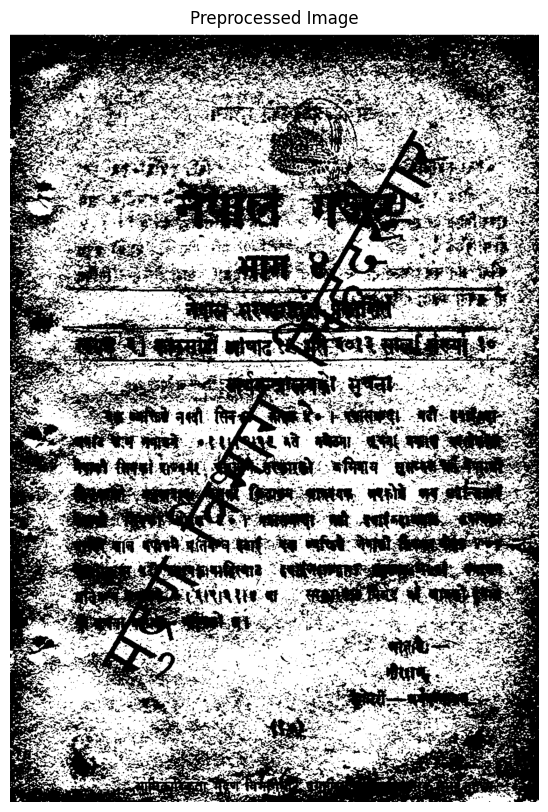

In [24]:
def display_image(image, title="Image"):
    # Convert image from BGR to RGB
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage
image_path = r"D:\custom_dataset\ocr all\oldd.png"
image1 = cv2.imread(image_path)
preprocessed_image = preprocess_image(image_path)
display_image(preprocessed_image, title="Preprocessed Image")

### PREPROCESS TRAINING DATA

In [31]:
import os 
from PIL import Image

raw_path = r"../dataset/raw/raw"
out_path = r"../dataset/unprepared/pages"
counter=40

for filename in os.listdir(raw_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        image_path = os.path.join(raw_path, filename)
    preprocessed_image = preprocess_image(image_path)
    new_filename = f'image_{counter}.jpg' 
    new_image_path = os.path.join(out_path, new_filename)
    cv2.imwrite(new_image_path,preprocessed_image)
    counter+=1

